In [1]:
# Add project root to path and import required modules
import sys; sys.path.append('../..')
import inflation, mesh, sheet_meshing
import numpy as np
import utils, py_newton_optimizer, benchmark
import visualization
from tri_mesh_viewer import TriMeshViewer, OffscreenTriMeshViewer
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os
import contextlib

In [2]:
# Define the output folder once here
output_folder = "T10cm_c2"

#Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

In [3]:
# Load mesh vertices/edges and fused points (internal non-inflating regions)
V, E = mesh.load_raw('Data/hinge1022.obj')
fusedPts =list(np.loadtxt('Data/t10v3.txt').reshape((-1, 2)))
holePts = []  # No holes in this example

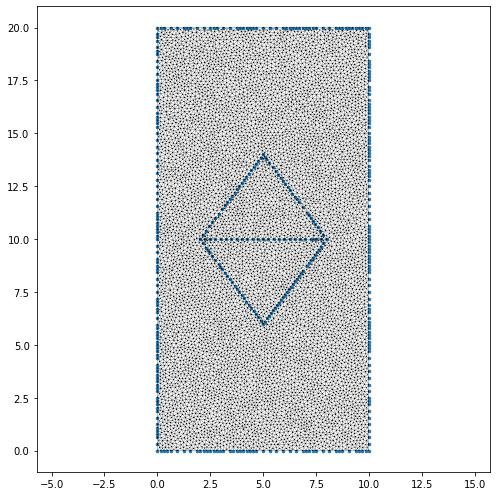

In [4]:
# Create the mesh for the inflatable sheet
m, iwv, iwbv = sheet_meshing.forward_design_mesh(
    V, E, fusedPts, holePts, np.prod(utils.bbox_dims(V)[0:2]) / 1e4
)

# Visualize the 2D mesh and highlight fused vertices
visualization.plot_2d_mesh(m, pointList=np.where(iwv)[0], width=7, height=7)

In [5]:
# Create the InflatableSheet object
isheet = inflation.InflatableSheet(m, iwv)

# Optionally set material properties if available
isheet.thickness = 0.015         # 0.15 mm (TPU nylon 70D)- in cm 
isheet.youngModulus = 2.5e9        # 250 MPa- 2500M dyn/cm 

In [6]:
# Define target points in 3D and find nearest mesh vertices for tracking
target_points = np.array([
    [0.00, 0.00, 0.0],
    [0.00, 10, 0.0],
    [0.00, 20, 0.0]# Export the deformed mesh as an OBJ file for further use (e.g., visualization in external tools)
])

# Get rest positions and find nearest actual vertices
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])######### v in isheet.restWallVertexPositions()

tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]

# Store rest positions for displacement calculation
rest_positions = {idx: V_rest[idx] for idx in tracked_indices}

print("Tracked indices:", tracked_indices)
print("Tracked coordinates:", [V_rest[i] for i in tracked_indices])

Tracked indices: [0, 12, 5]
Tracked coordinates: [array([0., 0., 0.]), array([ 0., 10.,  0.]), array([ 0., 20.,  0.])]


In [7]:
# Set up the on-screen viewer for interactive visualization
viewer = TriMeshViewer(isheet, width=768, height=640)
#viewer.setCameraParams(([0, 0, 5], [0, 1, 0], [0, 0, 0]))
viewer.showWireframe(True)
viewer.show()

Renderer(camera=PerspectiveCamera(aspect=1.2, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [8]:
# Set up dictionary to store trajectory over time
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5  # Save every 5 iterations

def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        viewer.update()  # Update on-screen viewer

# Set up optimizer options
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.useIdentityMetric = True
opts.beta = 1e-4
opts.gradTol = 1e-10
opts.niter = 500

# Set up simulation parameters
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
isheet.pressure = 2.5e3  # Adjust as needed

# ---- Pin your custom vertices here ----
#pins = np.array([[0, 0], [0, 10], [5, 10]])
#pin_indices = [np.argmin(np.linalg.norm(V[:, :2] - p, axis=1)) for p in pins]
#fixed_vars = []
#for idx in pin_indices:
#    fixed_vars.extend([3*idx, 3*idx+1, 3*idx+2])
# ---------------------------------------


benchmark.reset()
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()

InflatableSheet setVars	0.00172019	1
Newton iterations	249.04	1
    InflatableSheet energy	0.000488043	1
    InflatableSheet gradient	0.00105691	1
    Newton iterate	249.037	500
        Backtracking	4.12925	500
            InflatableSheet energy	0.778985	1155
            InflatableSheet setVars	3.2854	1155
        Compute descent direction	235.885	500
            newton_step	235.884	500
                Newton solve	221.475	510
                    CHOLMOD Numeric Factorize	216.072	509
                    Solve	4.83941	501
                        CHOLMOD Backsub	4.59738	500
                        CHOLMOD Numeric Factorize	0.0350969	1
                        CHOLMOD Symbolic Factorize	0.132299	1
                hessEval	14.3002	500
                largestMagnitudeEigenvalue	0.0558109	1
        Preamble	8.83018	500
            Callback	7.59526	500
            InflatableSheet energy	0.323922	500
            InflatableSheet gradient	0.806284	500
Full time	249.08


In [9]:
# Re-initialize the sheet if you want a fresh start for the video
isheet = inflation.InflatableSheet(m, iwv)
isheet.thickness = 0.015
isheet.youngModulus = 2.5e9
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
isheet.pressure = 2.5e3


opts.niter = 500  # or as needed

#
# ---- Pin your custom vertices here ----
#pins = np.array([[0, 0], [0, 10], [5, 10]])
#pin_indices = [np.argmin(np.linalg.norm(V[:, :2] - p, axis=1)) for p in pins]
#fixed_vars = []
#for idx in pin_indices:
#    fixed_vars.extend([3*idx, 3*idx+1, 3*idx+2])

# Set up offscreen viewer for video recording
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)
oview.setCameraParams(([-2.50, 5, 4.33], [0, 0, 1], [0, 0, 0]))# -30 F


# Tracking for video run
trajectory = {idx: [] for idx in tracked_indices}
def cb_video(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        oview.update()

benchmark.reset()

oview.recordStart(os.path.join(output_folder, "inflation_mp.mp4"))

cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb_video)

# Save benchmark report to text file
report_path = os.path.join(output_folder, "benchmark_report.txt")
with open(report_path, "w") as f:
    with contextlib.redirect_stdout(f):
        benchmark.report()
benchmark.report()
oview.recordStop()

InflatableSheet setVars	0.0030899	1
Newton iterations	346.464	1
    InflatableSheet energy	0.000340939	1
    InflatableSheet gradient	0.00110793	1
    Newton iterate	346.46	500
        Backtracking	4.99316	500
            InflatableSheet energy	0.965276	1079
            InflatableSheet setVars	3.88892	1079
        Compute descent direction	328.407	500
            newton_step	328.405	500
                Newton solve	310.433	510
                    CHOLMOD Numeric Factorize	303.264	509
                    Solve	6.52591	501
                        CHOLMOD Backsub	6.20809	500
                        CHOLMOD Numeric Factorize	0.021991	1
                        CHOLMOD Symbolic Factorize	0.201362	1
                hessEval	17.883	500
                largestMagnitudeEigenvalue	0.0435829	1
        Preamble	12.7628	500
            Callback	11.2344	500
            InflatableSheet energy	0.457998	500
            InflatableSheet gradient	0.910454	500
Full time	346.52


In [10]:
# Export the deformed mesh as an OBJ file for further use (e.g., visualization in external tools)
def write_obj(path, V, F):
    with open(path, "w") as f:
        for v in V:
            f.write("v {:.6f} {:.6f} {:.6f}\n".format(*v))
        for face in F:
            f.write("f {} {} {}\n".format(*(face + 1)))  # OBJ is 1-indexed

# Get the deformed geometry from the sheet
V_raw, F_raw, *_ = isheet.visualizationGeometry()
V = np.array([v.flatten() for v in V_raw], dtype=np.float64)
F = np.array([f for f in F_raw], dtype=np.int32)
# Save mesh to OBJ file
obj_path = os.path.join(output_folder, "infl_mesh_mp.obj")
write_obj(obj_path, V, F)

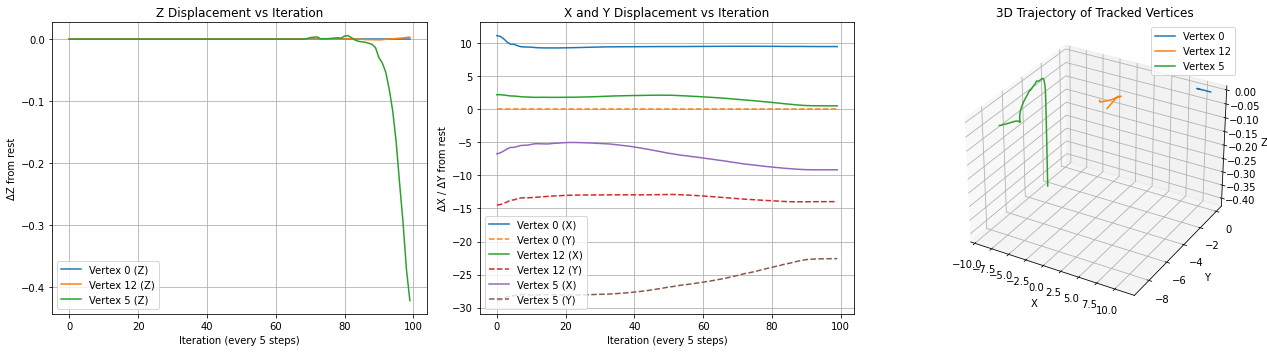

In [11]:
# Plot Z displacement, X/Y displacement, and 3D trajectory for tracked vertices
fig = plt.figure(figsize=(18, 5))

# Z Displacement
ax1 = fig.add_subplot(1, 3, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        z_disp = traj[:, 2] - rest_positions[idx][2]
        ax1.plot(range(len(traj)), z_disp, label=f"Vertex {idx} (Z)")
ax1.set_title("Z Displacement vs Iteration")
ax1.set_xlabel(f"Iteration (every {framerate} steps)")
ax1.set_ylabel("ΔZ from rest")
ax1.grid(True)
ax1.legend()

# X and Y Displacement
ax2 = fig.add_subplot(1, 3, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        x_disp = traj[:, 0] - rest_positions[idx][0]
        y_disp = traj[:, 1] - rest_positions[idx][1]
        ax2.plot(range(len(traj)), x_disp, label=f"Vertex {idx} (X)")
        ax2.plot(range(len(traj)), y_disp, linestyle='--', label=f"Vertex {idx} (Y)")
ax2.set_title("X and Y Displacement vs Iteration")
ax2.set_xlabel(f"Iteration (every {framerate} steps)")
ax2.set_ylabel("ΔX / ΔY from rest")
ax2.grid(True)
ax2.legend()

# 3D Trajectory
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        ax3.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax3.set_title("3D Trajectory of Tracked Vertices")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Z")
ax3.legend()

plt.tight_layout()
plt.savefig(f"{output_folder}/displacement.png", dpi=300)
plt.show()

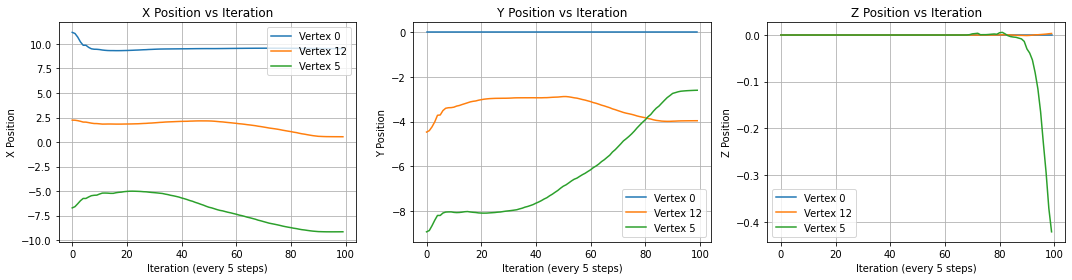

In [12]:
# Plot absolute X, Y, Z positions vs iteration for each tracked vertex
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    iterations = range(len(traj))
    axs[0].plot(iterations, traj[:, 0], label=f"Vertex {idx}")
    axs[1].plot(iterations, traj[:, 1], label=f"Vertex {idx}")
    axs[2].plot(iterations, traj[:, 2], label=f"Vertex {idx}")

# X
axs[0].set_title("X Position vs Iteration")
axs[0].set_xlabel(f"Iteration (every {framerate} steps)")
axs[0].set_ylabel("X Position")
axs[0].grid(True)
axs[0].legend()

# Y
axs[1].set_title("Y Position vs Iteration")
axs[1].set_xlabel(f"Iteration (every {framerate} steps)")
axs[1].set_ylabel("Y Position")
axs[1].grid(True)
axs[1].legend()

# Z
axs[2].set_title("Z Position vs Iteration")
axs[2].set_xlabel(f"Iteration (every {framerate} steps)")
axs[2].set_ylabel("Z Position")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.savefig(f"{output_folder}/position.png", dpi=300)
plt.show()

In [13]:
print("Target points:")
for p in target_points:
    print(p)
print("\nTracked indices and their rest positions:")
for idx in tracked_indices:
    print(f"Index: {idx}, Rest position: {rest_positions[idx]}")
    print(f"Distance to target: {np.linalg.norm(rest_positions[idx] - target_points[tracked_indices.index(idx)])}")

Target points:
[0. 0. 0.]
[ 0. 10.  0.]
[ 0. 20.  0.]

Tracked indices and their rest positions:
Index: 0, Rest position: [0. 0. 0.]
Distance to target: 0.0
Index: 12, Rest position: [ 0. 10.  0.]
Distance to target: 0.0
Index: 5, Rest position: [ 0. 20.  0.]
Distance to target: 0.0


In [14]:
# Define output file path
info_path = os.path.join(output_folder, "tracked_target_info.txt")

with open(info_path, "w") as f:
    with contextlib.redirect_stdout(f):
        print("Target points:")
        for p in target_points:
            print(p)

        print("\nTracked indices and their rest positions:")
        for idx in tracked_indices:
            print(f"Index: {idx}, Rest position: {rest_positions[idx]}")
            distance = np.linalg.norm(rest_positions[idx] - target_points[tracked_indices.index(idx)])
            print(f"Distance to target: {distance}")

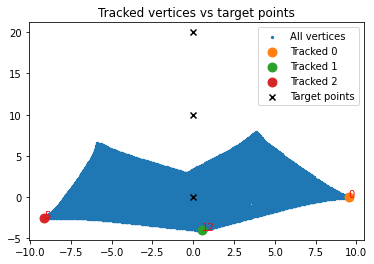

In [15]:
import matplotlib.pyplot as plt

V2d = np.array([v[:2] for v in V])  # If V is Nx3
plt.scatter(V2d[:,0], V2d[:,1], s=5, label='All vertices')
for i, idx in enumerate(tracked_indices):
    plt.scatter(V2d[idx,0], V2d[idx,1], s=80, label=f'Tracked {i}')
    plt.text(V2d[idx,0], V2d[idx,1], str(idx), color='red')
plt.scatter([p[0] for p in target_points], [p[1] for p in target_points], marker='x', color='k', label='Target points')
plt.legend()
plt.title("Tracked vertices vs target points")
plt.savefig(f"{output_folder}/trackedvstarget.png", dpi=300)
plt.show()

In [16]:
import csv

# Save trajectory data
csv_patht = os.path.join(output_folder, "tracked_vertices_trajectory.csv")
with open(csv_patht, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Vertex Index", "Frame", "X", "Y", "Z"])
    for idx in tracked_indices:
        traj = np.array(trajectory[idx])
        for i, pos in enumerate(traj):
            writer.writerow([idx, i, pos[0], pos[1], pos[2]])


In [17]:
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    file_path = os.path.join(output_folder, f"vertex_{idx}_trajectory.txt")
    np.savetxt(file_path, traj, header="X Y Z")


In [18]:
csv_path = os.path.join(output_folder, "tracked_vertices_displacement.csv")
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Vertex Index", "Frame", "ΔX", "ΔY", "ΔZ"])
    for idx in tracked_indices:
        traj = np.array(trajectory[idx])
        rest = rest_positions[idx]
        for i, pos in enumerate(traj):
            dx = pos[0] - rest[0]
            dy = pos[1] - rest[1]
            dz = pos[2] - rest[2]
            writer.writerow([idx, i, dx, dy, dz])

In [19]:
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    rest = rest_positions[idx]
    delta = traj - rest  # Element-wise subtraction
    txt_path = os.path.join(output_folder, f"vertex_{idx}_displacement.txt")
    np.savetxt(txt_path, delta, header="ΔX ΔY ΔZ")

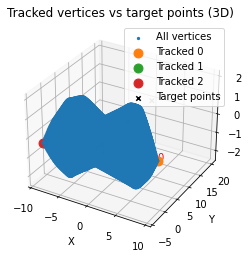

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all vertices
V3d = np.array(V)  # Make sure V is Nx3
ax.scatter(V3d[:, 0], V3d[:, 1], V3d[:, 2], s=5, label='All vertices')

# Plot tracked vertices
for i, idx in enumerate(tracked_indices):
    ax.scatter(V3d[idx, 0], V3d[idx, 1], V3d[idx, 2], s=80, label=f'Tracked {i}')
    ax.text(V3d[idx, 0], V3d[idx, 1], V3d[idx, 2], str(idx), color='red')

# Plot target points (assumed 2D → extend to 3D with Z=0)
target_points_3d = np.array([[p[0], p[1], 0] for p in target_points])
ax.scatter(target_points_3d[:, 0], target_points_3d[:, 1], target_points_3d[:, 2], 
           marker='x', color='k', label='Target points')

# Labels and title
ax.set_title("Tracked vertices vs target points (3D)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

# Save and show
plt.savefig(f"{output_folder}/trackedvstarget_3d.png", dpi=300)
plt.show()

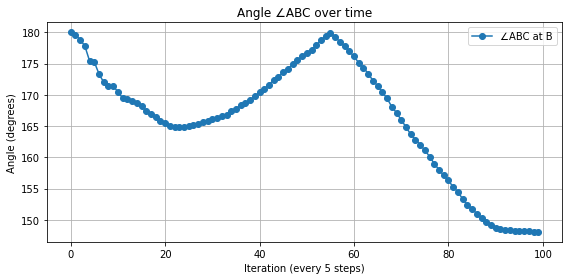

In [21]:
# Compute and plot angle ∠ABC over time using tracked vertex positions
# Assumes tracked_indices = [A, B, C] and trajectory is already populated
# Define vertex indices: A = lower point, B = middle, C = upper point
idx_A, idx_B, idx_C = tracked_indices  # e.g., (0,0,0), (0,10,0), (0,20,0)

angle_history = []

for t in range(len(trajectory[idx_B])):  # assume all lists same length
    A = np.array(trajectory[idx_A][t])
    B = np.array(trajectory[idx_B][t])
    C = np.array(trajectory[idx_C][t])

    BA = A - B
    BC = C - B

    norm_BA = np.linalg.norm(BA)
    norm_BC = np.linalg.norm(BC)

    if norm_BA > 1e-8 and norm_BC > 1e-8:
        cos_theta = np.dot(BA, BC) / (norm_BA * norm_BC)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)  # avoid numerical issues
        theta_deg = np.degrees(np.arccos(cos_theta))
    else:
        theta_deg = np.nan

    angle_history.append(theta_deg)

# Plot the angle over time
plt.figure(figsize=(8, 4))
plt.plot(angle_history, marker='o', label="∠ABC at B")
plt.title("Angle ∠ABC over time")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("Angle (degrees)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save plot as image
plt.savefig(os.path.join(output_folder, "angle_plot.png"))
plt.show()

# Optional: save angle data to CSV
csv_path_angle = os.path.join(output_folder, "angle_over_time.csv")
with open(csv_path_angle, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Frame", "Angle (degrees)"])
    for i, angle in enumerate(angle_history):
        writer.writerow([i, angle])


In [22]:
print(f"Last angle ∠ABC: {angle_history[-1]:.2f}°")


Last angle ∠ABC: 148.07°
